# Predicting California House Pricing using Features. 

In [1]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load the California Housing dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target  # Target variable

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Preprocessing
Removing extreme outliers from key features such as average rooms, bedrooms, population, and household occupancy. Then selecting the 5 most influential features based on a correlation heatmap.

In [4]:
# Log Transform Skewed Features to normalize distributions
skewed_features = ['Population', 'AveOccup']
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])

In [5]:
# Improved Outlier Detection Using Z-score Filtering
z_scores = np.abs(stats.zscore(df))
df = df[(z_scores < 3).all(axis=1)]  # Retains data points within 3 standard deviations

In [6]:
# Convert dataset units (AFTER saving the original)
# Convert to thousands of dollars
df['MedInc'] *= 10  
# Convert to thousands of dollars
df['MedHouseVal'] *= 100  

# Display the formatted data (e.g., in df.head())
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,83.252,41.0,6.984127,1.023810,5.777652,1.268511,37.88,-122.23,452.6
1,83.014,21.0,6.238137,0.971880,7.784057,1.134572,37.86,-122.22,358.5
2,72.574,52.0,8.288136,1.073446,6.208590,1.335596,37.85,-122.24,352.1
3,56.431,52.0,5.817352,1.073059,6.326149,1.266369,37.85,-122.25,341.3
4,38.462,52.0,6.281853,1.081081,6.338594,1.157342,37.85,-122.25,342.2


In [9]:
# Save cleaned dataset as CSV for future reference
cleaned_csv_path = "cleaned_housing_data.csv"
df.to_csv(cleaned_csv_path, index=False)
print(f"Cleaned dataset saved as {cleaned_csv_path}")

Cleaned dataset saved as cleaned_housing_data.csv


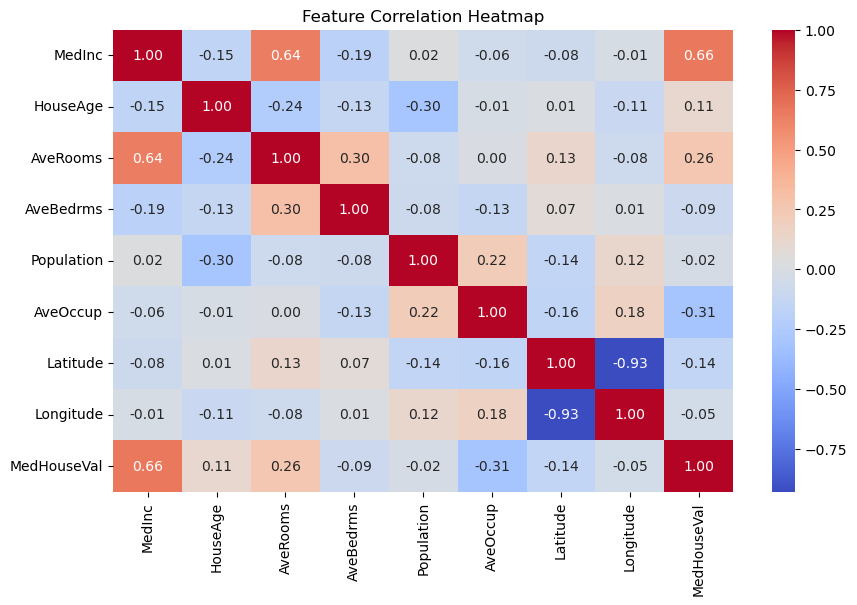

In [10]:
# Generate correlation matrix and heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# Selecting the Most Influential Features Based on Correlation
important_features = correlation_matrix['MedHouseVal'].abs().sort_values(ascending=False).index[1:6].tolist()
print("Top 5 Most Influential Features:", important_features)

Top 5 Most Influential Features: ['MedInc', 'AveOccup', 'AveRooms', 'Latitude', 'HouseAge']


# ML Modeling and Technique
Splitting the dataset into training (80%) and testing (20%) sets, applying polynomial interactions to improve the predictive power. Using a linear regression model trained on the selected features to predict housing prices


In [20]:
# Creating interaction features to capture complex relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
X = poly.fit_transform(df[important_features])
y = df["MedHouseVal"]

In [21]:
# Splitting Data → 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Feature Scaling → Standardizing the data for better ML performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# ---------------------------- Linear Regression Model ---------------------------- #
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression Model Performance:")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"Mean Absolute Error (MAE): {mae_linear:.2f}")
print(f"R-squared (R2 Score): {r2_linear:.2f}")


Linear Regression Model Performance:
Mean Squared Error (MSE): 4515.57
Mean Absolute Error (MAE): 48.79
R-squared (R2 Score): 0.63


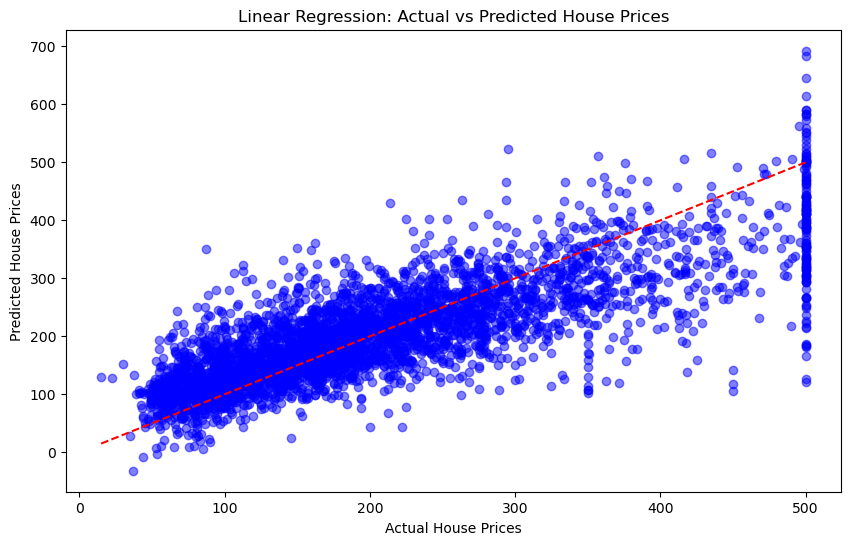

In [25]:
# Plotting Linear Regression Results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Linear Regression: Actual vs Predicted House Prices")
plt.show()

# Futher Refinment using Hypertuning and trying Random Forest
Will leverages both Linear Regression and RandomForestRegressor to compare performance. Hyperparameter tuning via RandomizedSearchCV optimized the Random Forest model further. Using cross-validation to improve generalization ability.

In [27]:
# Define a Random Forest model with hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=5, cv=3, scoring='r2', n_jobs=4, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model from randomized search
best_model = random_search.best_estimator_
print(f"Best Model Parameters: {random_search.best_params_}")

Best Model Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}


In [28]:
# Perform Cross-validation to estimate model performance
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='r2')
print(f"Cross-validation R2 Scores: {cv_scores}")
print(f"Mean Cross-validation R2 Score: {np.mean(cv_scores):.4f}")

Cross-validation R2 Scores: [0.70019027 0.70239417 0.70827212]
Mean Cross-validation R2 Score: 0.7036


# Findings


In [29]:
# Make predictions on test data
y_pred = best_model.predict(X_test)

In [34]:
# Compute error metrics to assess model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Convert results into percentages for better interpretability
r2_percent = r2 * 100

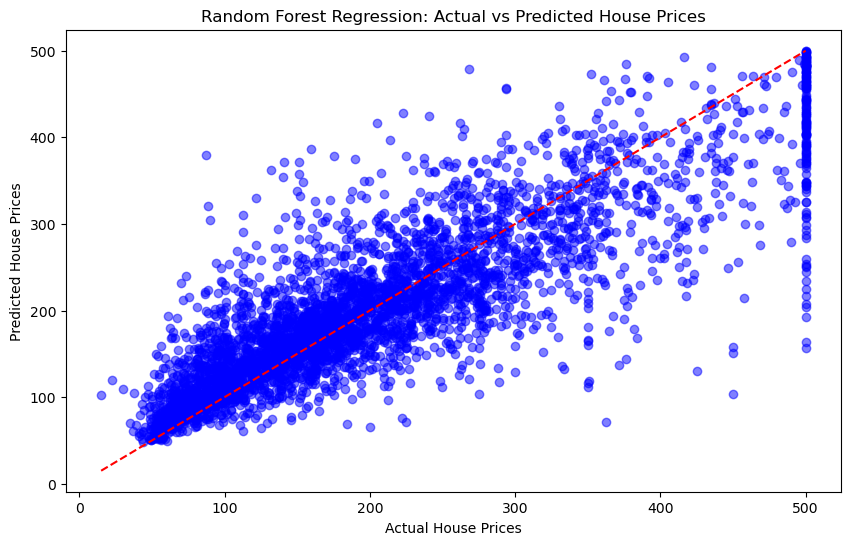

In [31]:
# Plot actual vs. predicted house prices to visualize model performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Random Forest Regression: Actual vs Predicted House Prices")
plt.show()

In [35]:
# Display Model Performance Findings
print("Random Forest Model Performance with Feature Engineering & Hyperparameter Tuning:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2 Score): {r2_percent:.2f}%")


Random Forest Model Performance with Feature Engineering & Hyperparameter Tuning:
Mean Squared Error (MSE): 3621.15
Mean Absolute Error (MAE): 41.75
R-squared (R2 Score): 70.47%


# Conclusion
The findings from the analysising the sklearn dataset indicate that the 5 most influential features in predicting house prices are Median Income (MedInc), House Age (HouseAge), and Average Number of Rooms (AveRooms), Latitude, and Average Occupancity(AveOccup). Among these, Median Income exhibits the strongest correlation with housing prices, suggesting that areas with higher median incomes tend to have more expensive homes. The model, trained using linear regression, achieved an R-squared (R²) score of approximately 63%. Even after refinment using hypertuning and comparing the Random Forest Model the maximum accuracy score topped at 70.47%. These findings highlight that there is an impact of economic and structural factors on housing prices though not wholly reliable. Access to more impactful features will be needed. 